<a href="https://colab.research.google.com/github/tikendraw/Stock_price_prediction_NSE_NASDAQ/blob/main/stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Price Predictions

In [3]:
import os
import sys

if 'google.colab' in str(get_ipython()) :
    !pip install yfinance --quiet
    !pip install pandas-datareader -q

    !git clone https://github.com/tikendraw/Stock_price_prediction_NSE_NASDAQ.git
    os.chdir('Stock_price_prediction_NSE_NASDAQ')

Cloning into 'Stock_price_prediction_NSE_NASDAQ'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 36 (delta 6), reused 32 (delta 5), pack-reused 0
Unpacking objects: 100% (36/36), 1.56 MiB | 4.77 MiB/s, done.


In [5]:
# import modules
from datetime import datetime

import yfinance as yf
import matplotlib.pyplot as plt
import datetime
import time
from pandas_datareader import data as pdr
import yfinance as yf
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, losses, callbacks
from tensorflow.keras.preprocessing.sequence import  TimeseriesGenerator
import pandas as pd
import numpy as np
import os 
from pathlib import Path
from update_stock_symbols import get_stock_symbols

In [6]:
main_path = Path.cwd()
print(main_path)

/content/Stock_price_prediction_NSE_NASDAQ


In [7]:
#updating the list
get_stock_symbols() 

Getting stock symbols...
Updated.


In [8]:
# os.system('rm -rf src')

In [9]:
# creating data path and Moving downloaded files
dataset_dir = main_path / 'dataset'
dataset_dir.mkdir(exist_ok = True)

comp1 = 'AAPL'

HIST = 5


In [10]:
companies = [comp1]

In [11]:
companies_data = {}
for comp in companies:
    yf.pdr_override() # <== that's all it takes :-)

    # download dataframe
    years = 5
    end_date = str(datetime.date.today()) # today
    start_date = str(datetime.date.today() - datetime.timedelta(days= years*365)) # some years from now
    
    data = pdr.get_data_yahoo(comp, start=start_date, end=end_date)
    data.to_csv(f'{dataset_dir}/{comp}-{start_date}.csv')
    companies_data[comp]=data

[*********************100%***********************]  1 of 1 completed


In [12]:
df = companies_data['AAPL']

In [13]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-02-24,147.110001,147.190002,145.720001,146.710007,146.710007,55469600
2023-02-27,147.710007,149.169998,147.449997,147.919998,147.919998,44998500
2023-02-28,147.050003,149.080002,146.830002,147.410004,147.410004,50547000
2023-03-01,146.830002,147.229996,145.009995,145.309998,145.309998,55479000
2023-03-02,144.380005,146.710007,143.899994,145.910004,145.910004,52238100


In [14]:
df.shape

(1258, 6)

## Creating dataset

We need to create a dataset that moves with time and creates windows(features) and Horizons(label)

1. One to one dataset (One feature column and One Label)
    
    e.g. feature Adj Close --> Adj Close
2. Many to One dataset (All the Features and One Label)
    
    e.g. [Open, High, Low, Close, Adj Close, Volume] --> Adj Close

In [15]:
# setting a columns to be predicted
wanted = 'Adj Close'
price = df[wanted].to_numpy()
time = df[wanted].index.to_numpy()

# show some prices
print(price)

[ 42.14156723  42.10580826  41.71494675 ... 147.41000366 145.30999756
 145.91000366]


In [16]:
len(price)

1258

In [17]:
WINDOW_SIZE = 3
HORIZON = 1
class WindowMaker:
    '''
    dataclass returns windows and horizons with given parameter

    -------------------
    Parameters:
        data:nd array       :   numpy array or pandas dataframe
        window_size:int     :   size of the window
        horizon_size:int    :   size of the horizon

        stride:int          :   how much window slides on data
        shift:int           :   gap between window and horizon(if needed) 

    '''
    from sklearn.model_selection import train_test_split

    def __init__(self, data: pd.DataFrame , window_size:int=7, horizon_size:int=1, label_columns_indices:list=None,label_columns_names:list = None, stride:int = 1, shift:int=0):
        self.data = data
        self.window_size = window_size
        self.horizon_size = horizon_size
        self.label_columns_indices = label_columns_indices
        self.label_columns_names = label_columns_names
        self.stride = stride
        self.shift = shift




        ## getting label indices
        if type(self.data) == pd.core.frame.DataFrame:

            self.column_indices = {name: i for i, name in
                                enumerate(self.data.columns)}

            if self.label_columns_names is not None:
                self.label_columns_indices = [self.column_indices[name]  for name in
                                        self.label_columns_names]
            
            # converting dataframe to ndarray
            self.data = self.data.to_numpy()


        # create a array of window size
        self.window_size_array = np.arange(self.window_size + self.shift + self.horizon_size)

        # create array with a forward shift
        self.all_array_index = np.arange(len(self.data)- (self.window_size + self.shift + self.horizon_size -1), step = self.stride).reshape(-1,1) + self.window_size_array

        # Spliting index in window and horizon
        self.all_windows_index = self.all_array_index[:, :self.window_size]
        self.all_horizons_index = self.all_array_index[:, self.window_size+self.shift:]


        # actuall values of horizon and windows
        self.all_windows = self.data[self.all_windows_index]
        self.all_horizons_full = self.data[self.all_horizons_index] # contains all the labels

        # Work out the label column indices.
        if self.label_columns_indices is not None:
            self.all_horizons = self.all_horizons_full[...,self.label_columns_indices]
        
        else:
            self.all_horizons = self.all_horizons_full


    def make_split(self):
        return self.all_windows, self.all_horizons

    # returns train, test or train, val, test as tuple
    def train_test_val(self,test_size:float = .1, val_size:float = None,random = False, random_state:int = 2):
        if random == True:
            # creating test data of test_size
            if test_size is not None:
                if random:
                    xtrain_rest, xtest, ytrain_rest, ytest = train_test_split(self.all_windows, self.all_horizons, test_size = test_size,shuffle=True, random_state = random_state)
                else:
                    xtrain_rest, xtest, ytrain_rest, ytest = train_test_split(self.all_windows, self.all_horizons, test_size = test_size, random_state = random_state)
                if val_size is None:
                    return (xtrain_rest, ytrain_rest), (xtest, ytest)
                if val_size is not None:
                    xtrain, xval, ytrain, yval = train_test_split(xtrain_rest, ytrain_rest, test_size = val_size, random_state = random_state)
                    return (xtrain, ytrain),( xval, yval), (xtest, ytest)
            else:
                raise ValueError('test_size can not be None, To just create val data use test_size')

        else:
            # creating test data of test_size
            if test_size is not None:
                test_len = int(len(self.all_windows)* test_size)
                xtrain_rest, xtest, ytrain_rest, ytest = self.all_windows[:-test_len], self.all_windows[-test_len:], self.all_horizons[:-test_len], self.all_horizons[-test_len:]
                if val_size is None:
                    return (xtrain_rest, ytrain_rest), (xtest, ytest)
                if val_size is not None:

                    val_len = int(len(xtrain_rest)* val_size)
                    xtrain, xval, ytrain, yval = xtrain_rest[:-val_len], xtrain_rest[-val_len:], ytrain_rest[:-val_len], ytrain_rest[-val_len:]
                    return (xtrain, ytrain),( xval, yval), (xtest, ytest)
            else:
                raise ValueError('test_size can not be None, To just create val data use test_size')           

        

    def plot(self, plot_cols:list=None, model = None, figsize = (15,5),**kwargs):
        # plots data
        plt.figure(figsize = figsize)
        plt.grid(True)
        for i, name in enumerate(plot_cols):
            plt.subplot(len(plot_cols),1, i+1)
            plt.plot(self.all_horizons_full[...,self.column_indices[name]], **kwargs)
            plt.title(name)
            # if model is not None:
            #     predictions = model.pred
            # plt.plot(self.all_horizons_full[...,self.columns_indices[name]])
        plt.show()

    def __repr__(self):
        return '\n'.join([
                f'Total window size: {self.window_size}',
                f'Horizon size: {self.horizon_size}',            # if model is not None:
            #     predictions = model.pred
            # plt.plot(self.all_horizons_full[...,self.columns_indices[name]])
                f'Stride: {self.stride}',
                f'Shift: {self.shift}'])

In [18]:
wfull = WindowMaker(price, horizon_size=1, label_columns_names = [wanted])

In [19]:
windows, horizons = wfull.make_split()

In [20]:
windows.shape, horizons.shape

((1251, 7), (1251, 1))

In [21]:
horizons

array([[ 42.52766037],
       [ 42.57770157],
       [ 42.4275589 ],
       ...,
       [147.41000366],
       [145.30999756],
       [145.91000366]])

In [22]:
train_data, val_data = wfull.train_test_val(random_state = 3)

In [23]:
train_data[0].shape,train_data[1].shape , val_data[0].shape, val_data[1].shape

((1126, 7), (1126, 1), (125, 7), (125, 1))

In [24]:
def compile_and_fit(model, train_data, val_data = None, epochs = 100, patience = 5, verbose = 1, ckpt_verbose = 1):

    # callbacks
    EarlyStopping = callbacks.EarlyStopping(monitor='mae', patience = patience )

    filepath = os.path.join('modelckpt', model.name)

    try:
        os.makedirs(filepath)
    except:
        pass

    ModelCheckpoint = callbacks.ModelCheckpoint(filepath= filepath,
                                                monitor = 'val_loss',
                                                verbose = ckpt_verbose,
                                                save_best_only = True,
                                                save_weights_only = True)
    
    # compile
    model.compile(loss = 'mae',
                  optimizer = 'adam',
                  metrics = ['mse', 'mae'])
    
    history = model.fit(train_data, epochs = epochs, 
                        validation_data= val_data,
                        batch_size = 32,
                        verbose = verbose,
                        callbacks = [ModelCheckpoint])
    print('metrics order :Loss, MSE, MAE')
    print('Train data Evaluation: ', model.evaluate(train_data))
    print('Validation data Evaluation: ',model.evaluate(val_data))
    
    return history

In [25]:
def pred_plot(model, val_data, figsize = (25,7)):
    x= val_data.unbatch().as_numpy_iterator()
    yval = [i[1] for i in list(x)]
    xval = [i[0] for i in list(x)]

    # bigpred = []
    print(xval)
    ypred = tf.squeeze(model.predict(val_data))

    # print(np.arange(1,len(ypred)+1))
    #plot it 
    plt.figure(figsize = figsize)
    plt.grid(True)
    plt.plot(np.arange(1,len(ypred)+1),yval, marker = 'o', label = 'ytrue')
    plt.plot(np.arange(1,len(ypred)+1),ypred, marker = 'x', label = 'ypred')
    # plt.ylim(min(price), max(price))
    plt.legend()
    a = np.array(ypred)
    b = np.array(yval)

    mae = np.mean(np.abs(a-b)) 
    plt.title(f'mae: {mae}')

In [26]:
# MASE implemented courtesy of sktime - https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16
def mean_absolute_scaled_error(y_true, y_pred):
    """
    Implement MASE (assuming no seasonality of data).
    """
    mae = tf.reduce_mean(tf.abs(y_true - y_pred))

    # Find MAE of naive forecast (no seasonality)
    mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

    return mae / mae_naive_no_season

In [27]:
def result(model: tf.keras.Model, test_data):
    # Make sure float32 (for metric calculations)
    x= test_data.unbatch().as_numpy_iterator()
    y_true = [i[1] for i in list(x)]
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_true = tf.squeeze(y_true)

    y_pred = tf.squeeze(model.predict(test_data))

    y_pred = tf.cast(y_pred, dtype=tf.float32)
    # print(y_pred, y_true)
    # Calculate various metrics
    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mase = mean_absolute_scaled_error(y_true, y_pred)

    result =  {"mae": mae.numpy(),
            "mse": mse.numpy(),
            "rmse": rmse.numpy(),
            "mape": mape.numpy(),
            "mase": mase.numpy()}

    # print(result)
    return result

## Spliting the dataset ( Train, Test, Val)


In [28]:
wfull = WindowMaker(price, horizon_size=1, label_columns_names = [wanted])

In [29]:
wfull

Total window size: 7
Horizon size: 1
Stride: 1
Shift: 0

In [30]:
windows, horizons = wfull.make_split()

In [31]:
windows.shape, horizons.shape

((1251, 7), (1251, 1))

In [32]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

WindowMaker.make_dataset = make_dataset

In [33]:
train_data, val_data, test_data = wfull.train_test_val(test_size=.1, val_size=.1,random_state = 3)

In [34]:
BATCH_SIZE = 32

In [35]:
train_data = tf.data.Dataset.from_tensor_slices(train_data).batch(BATCH_SIZE)
val_data = tf.data.Dataset.from_tensor_slices(val_data).batch(BATCH_SIZE)
test_data = tf.data.Dataset.from_tensor_slices(test_data).batch(BATCH_SIZE)

In [36]:
print(f'train_data:  {len(train_data)*BATCH_SIZE:2} :: {train_data}')
print(f'val_data:    {len(val_data)*BATCH_SIZE:4} :: {val_data}')
print(f'test_data:   {len(test_data)*BATCH_SIZE:4} :: {test_data} ')

train_data:  1024 :: <BatchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>
val_data:     128 :: <BatchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>
test_data:    128 :: <BatchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))> 


# Model 0: Persistence Algorithm (the “naive” forecast)
The most common baseline method for supervised machine learning is the Zero Rule algorithm.

This algorithm predicts the majority class in the case of classification, or the average outcome in the case of regression. This could be used for time series, but does not respect the serial correlation structure in time series datasets.

The equivalent technique for use with time series dataset is the persistence algorithm.

The persistence algorithm uses the value at the previous time step (t-1) to predict the expected outcome at the next time step (t+1).

This satisfies the three above conditions for a baseline forecast.

To make this concrete, we will look at how to develop a persistence model and use it to establish a baseline performance for a simple univariate time series problem. First, let’s review the Shampoo Sales dataset.



In [37]:
rand_int = np.random.randint(5,100, (4,1,1,1,4))  
rand_int = np.squeeze(rand_int)

rand_int

array([[49, 59, 43, 37],
       [25, 72, 50, 60],
       [44, 35,  8, 33],
       [79, 49, 25, 48]])

In [38]:
# Baseline
# it just returns a value ahead ( basically predicting the Exact future)

class Baseline(tf.keras.Model):

    def __init__(self):
        super().__init__()
        # self.label_index = label_index

    
    def call(self, inputs):
        # x = self.dense1(inputs)
        # if training:
        #   x = self.dropout(x, training=training)
        tf.print(inputs[1])
        return inputs
    def predict(self, inputs):
        x= inputs.unbatch().as_numpy_iterator()
        y_true = [i[1] for i in list(x)]
        y_true = tf.cast(y_true, dtype=tf.float32)
        # y_true = y_true[:, :, tf.newaxis]
        # tf.print(inputs[1])
        return y_true


In [39]:
column_indices = {col: idx for idx, col in enumerate(df)}
column_indices

{'Open': 0, 'High': 1, 'Low': 2, 'Close': 3, 'Adj Close': 4, 'Volume': 5}

In [40]:
baseline = Baseline() #(label_index=column_indices[wanted])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])


In [41]:
eval1 = baseline.evaluate(val_data)
eval1

[154.156158 158.629059 159.652878 ... 164.384216 167.803497 169.185135]
1/4 [======>.......................] - ETA: 6s - loss: 38.3702 - mean_absolute_error: 4.8719[156.700745 157.008881 158.51973 ... 155.826065 156.562668 151.366486]
[134.812317 129.466812 130.959976 ... 134.732697 137.639374 141.013916]
[159.280212 165.372314 165.053772 ... 164.346024 164.395859 168.702148]
4/4 [==============================] - 2s 22ms/step - loss: 42.2246 - mean_absolute_error: 5.2143


[42.22459030151367, 5.2142510414123535]

In [42]:

val_performance = {}
performance = {}

val_performance['Baseline'] = {'mae': None,
                               'mse': None,
                               'rmse': None,
                               'mape': None,
                               'mase': None}


In [43]:
val_performance

{'Baseline': {'mae': None,
  'mse': None,
  'rmse': None,
  'mape': None,
  'mase': None}}

In [44]:
# result(Baseline, test_data)

[]


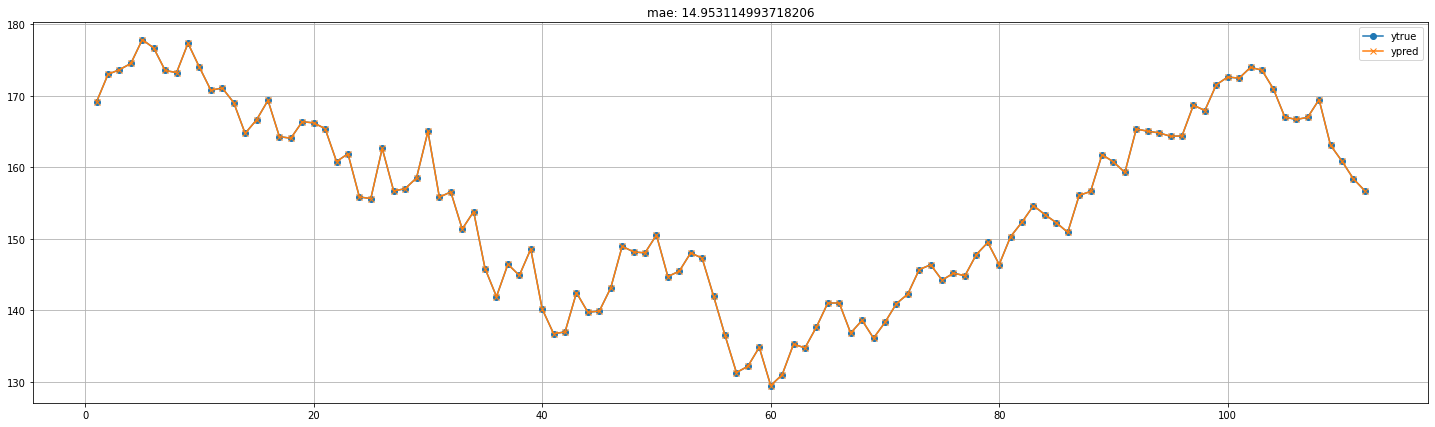

In [45]:
pred_plot(baseline, val_data)

# Model 1 : a Dense Model

In [46]:

model1 = keras.Sequential([
    layers.Dense(128, activation = 'relu'),
    layers.Dense(1)
], name = 'model1_dense')

In [47]:
compile_and_fit(model1, train_data, val_data,epochs = 200, verbose = 0, ckpt_verbose = 0)

metrics order :Loss, MSE, MAE
32/32 [==============================] - 0s 3ms/step - loss: 1.3002 - mse: 3.8022 - mae: 1.3002
Train data Evaluation:  [1.3001539707183838, 3.80220103263855, 1.3001539707183838]
4/4 [==============================] - 0s 6ms/step - loss: 2.6684 - mse: 11.2506 - mae: 2.6684
Validation data Evaluation:  [2.6684231758117676, 11.250550270080566, 2.6684231758117676]


[]
4/4 [==============================] - 0s 4ms/step


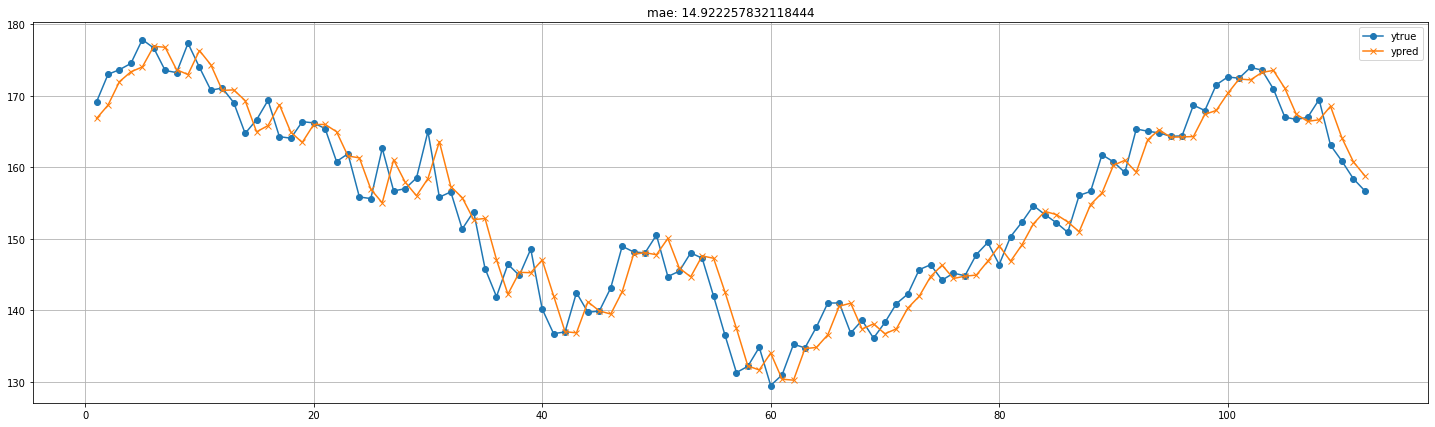

In [48]:
pred_plot(model1, val_data)

The Graph above shows the comparison between actual points and predicted points only. 
Note: Predicted prices are not very diffe

In [49]:
val_performance['model1'] = result(model1, val_data)

4/4 [==============================] - 0s 4ms/step


In [50]:
val_performance

{'Baseline': {'mae': None,
  'mse': None,
  'rmse': None,
  'mape': None,
  'mase': None},
 'model1': {'mae': 2.6684222,
  'mse': 11.250547,
  'rmse': 3.3541837,
  'mape': 1.7459888,
  'mase': 1.0094334}}

# Model 2 : a LSTM Model

In [51]:
@tf.function
def add_axis(x):
    # print(x.shape)
    x = x[:,:,tf.newaxis]
    # print(x.shape)
    return x

In [52]:
xxx  = val_data.unbatch().as_numpy_iterator()
xxy = [i[0] for i in xxx]
xxy = np.array(xxy)

In [53]:
# xxy = add_axis(xxy)
# xxy

In [54]:

model2 = keras.Sequential([
    layers.Lambda(add_axis),
    layers.LSTM(128),
    layers.Dense(1)
], name = 'model2_lstm')

In [55]:
compile_and_fit(model2, train_data, val_data,epochs = 200, verbose = 0, ckpt_verbose = 0)

metrics order :Loss, MSE, MAE
32/32 [==============================] - 0s 6ms/step - loss: 4.4160 - mse: 28.1387 - mae: 4.4160
Train data Evaluation:  [4.416045665740967, 28.138694763183594, 4.416045665740967]
4/4 [==============================] - 0s 8ms/step - loss: 5.5885 - mse: 42.6690 - mae: 5.5885
Validation data Evaluation:  [5.5885009765625, 42.66903305053711, 5.5885009765625]


[]
4/4 [==============================] - 1s 6ms/step


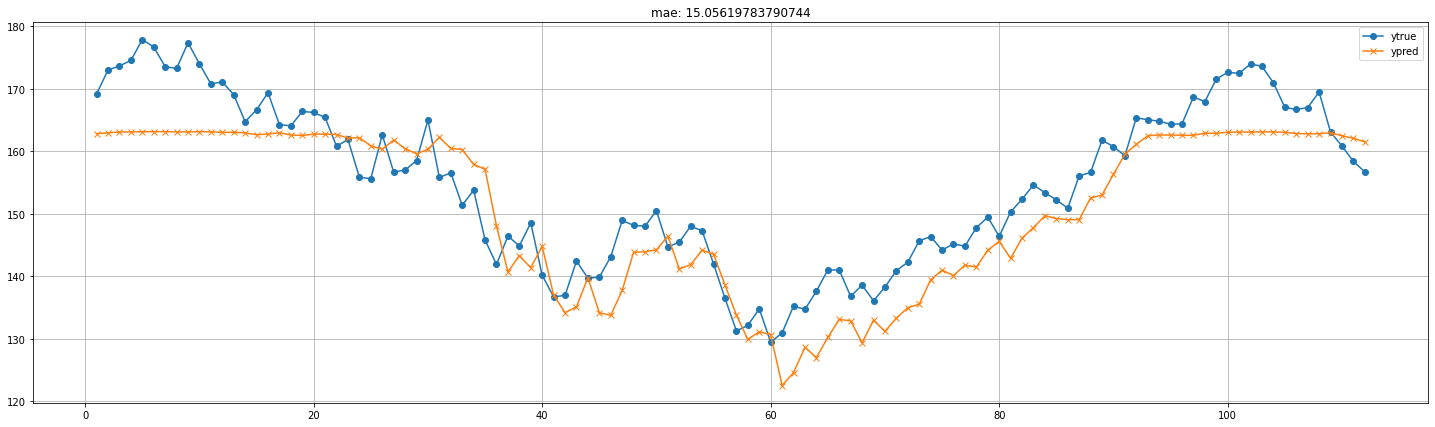

In [56]:
pred_plot(model2, val_data)

The Graph above shows the comparison between actual points and predicted points only. 
Note: Predicted prices are not very diffe

In [57]:
val_performance['model2'] = result(model2, val_data)

4/4 [==============================] - 0s 6ms/step


In [58]:
val_performance

{'Baseline': {'mae': None,
  'mse': None,
  'rmse': None,
  'mape': None,
  'mase': None},
 'model1': {'mae': 2.6684222,
  'mse': 11.250547,
  'rmse': 3.3541837,
  'mape': 1.7459888,
  'mase': 1.0094334},
 'model2': {'mae': 5.588502,
  'mse': 42.66904,
  'rmse': 6.5321546,
  'mape': 3.5864341,
  'mase': 2.114066}}

# Model 3 : a LSTM with State Model

In [59]:
@tf.function
def add_axis(x):
    # print(x.shape)
    x = x[:,:,tf.newaxis]
    # print(x.shape)
    return x

In [60]:

inputs3 = keras.Input(shape=(1)    )
x = layers.Lambda(add_axis)(inputs3)
x = layers.LSTM(7,return_sequences=True, return_state=True)(x)
x = layers.LSTM(7)(x)
# outputs3 = layers.MaxPooling1D()(x)
outputs3 = layers.Dense(1)(x)
 
model3 = keras.Model(inputs = inputs3, outputs = outputs3, name = 'model3_lstm')



In [61]:
compile_and_fit(model3, train_data, val_data, epochs = 200, verbose = 0, ckpt_verbose = 0)

metrics order :Loss, MSE, MAE
32/32 [==============================] - 0s 4ms/step - loss: 42.0016 - mse: 3370.0928 - mae: 42.0016
Train data Evaluation:  [42.001617431640625, 3370.0927734375, 42.001617431640625]
4/4 [==============================] - 0s 5ms/step - loss: 104.6022 - mse: 11110.0791 - mae: 104.6022
Validation data Evaluation:  [104.60215759277344, 11110.0791015625, 104.60215759277344]


[]
4/4 [==============================] - 0s 6ms/step


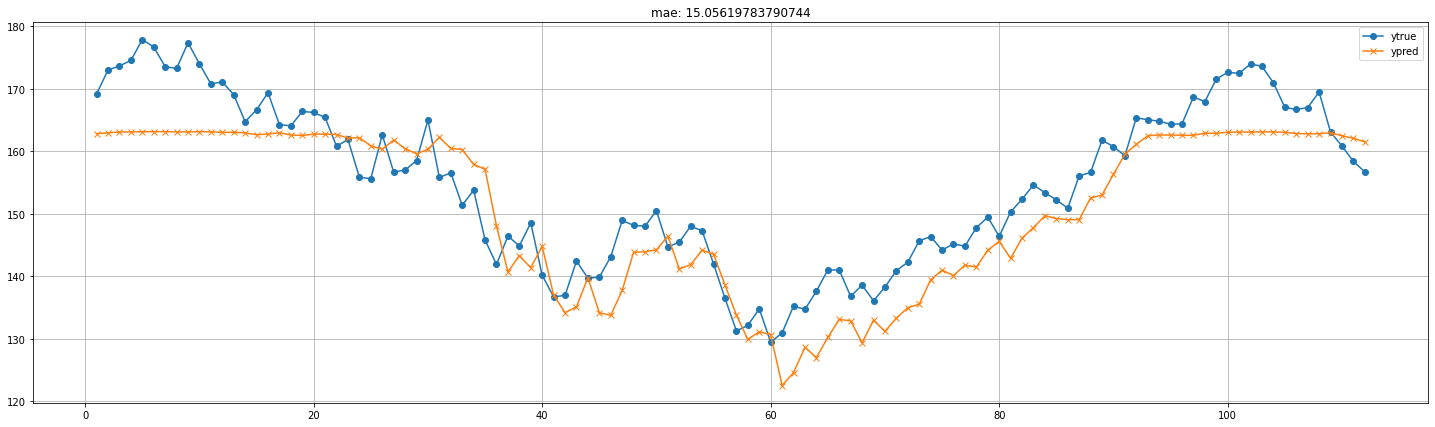

In [62]:
pred_plot(model2, val_data)

The Graph above shows the comparison between actual points and predicted points only. 
Note: Predicted prices are not very diffe

In [63]:
val_performance['model3'] = result(model3, val_data)

4/4 [==============================] - 1s 5ms/step


In [64]:
val_performance
pd.DataFrame(val_performance)

,Baseline,model1,model2,model3
mae,None,2.668422,5.588502,104.602158
mse,None,11.250547,42.669041,11110.080078
rmse,None,3.354184,6.532155,105.404366
mape,None,1.745989,3.586434,67.236641
mase,None,1.009433,2.114066,39.569790


In [65]:
#

In [66]:
from sklearn.ensemble import GradientBoostingRegressor

In [67]:
model4 = GradientBoostingRegressor()

In [68]:
train = list(train_data.unbatch().as_numpy_iterator())

X  = np.array([i[0] for i in train])
y  = np.array([i[1] for i in train])


In [69]:
val = list(val_data.unbatch().as_numpy_iterator())

Xval  = np.array([i[0] for i in val])
yval  = np.array([i[1] for i in val])


In [70]:
X.shape, y.shape

((1014, 7), (1014, 1))

In [71]:
y =  np.squeeze(y)
yval =  np.squeeze(yval)

In [72]:
model4.fit(X,y)

GradientBoostingRegressor()

In [73]:
ypred4 = model4.predict(Xval)

In [74]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [75]:

model4_results = {  
    'mae': mean_absolute_error(yval, ypred4),
    'mse': mean_squared_error(yval, ypred4),
    'rmse': mean_squared_error(yval, ypred4, squared=False),
    'mape' : tf.keras.metrics.mean_absolute_percentage_error(yval, ypred4),
    'mase' : mean_absolute_scaled_error(yval, ypred4)}

In [76]:
val_performance['model4'] = model1_result

NameError: ignored